<a href="https://colab.research.google.com/github/carlosarroyave/AutoEnc-GAN/blob/main/AE-GAMCAm%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 32.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Att

In [1]:
import numpy as np
import keras
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
!pip install tf-keras-vis tensorflow
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
from tf_keras_vis.utils.scores import CategoricalScore, InactiveScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00


In [2]:
print(tf. __version__)

2.10.1


In [3]:
def plot_mnist_autoencoder(x,xpred,cmap='gray',vmin=0,vmax=1):
  fig,ax = plt.subplots(2,x.shape[0],figsize=(20,5))
  for i,class_ in enumerate(range(x.shape[0])):
        ax[0,i].imshow(x[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])

        ax[1,i].imshow(xpred[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
  plt.show()
  return

## DataSet utlizado de keras fashion_mnist

El dataset esta calsificado en las siguientes clases :  # T-shirt/top, 	Trouser, Pullover,	Dress, 	Coat, Sandal, Shirt, 	Sneaker, Bag, Ankle boot

4422102/4422102 [==============================] - 0s 0us/step


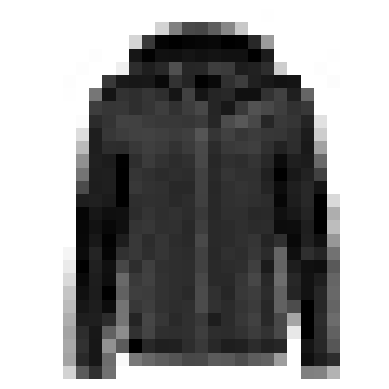

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Se mezclan los datos para garantizar que el modelo no tenga overfitting por el orden de los datos en el entrenamiento.

In [5]:
tamano = len(X_train)
indice_mezcla = np.random.permutation(tamano)
x_tr = X_train[indice_mezcla].reshape([tamano,28,28,1])
y_train = y_train[indice_mezcla]
tamano = len(X_valid)
indice_mezcla = np.random.permutation(tamano)
x_vl = X_valid[indice_mezcla].reshape([tamano,28,28,1])
y_valid = y_valid[indice_mezcla]
tamano = len(X_test)
indice_mezcla = np.random.permutation(tamano)
x_ts = X_test[indice_mezcla].reshape([tamano,28,28,1])
y_test = y_test[indice_mezcla]

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)


# Modelo Autoencoder con detección

Se crea un modelo de autoencoder que comparte la capa latente con otra red de clasificación para las 10 clases que se tienen

ArqAE_Dis.svg

In [6]:

# Hiper parametro de dimencion de media y logvar
dimVAr = 10
reconstruction_weight = 0.0005
kl_weight = 0.002
class_weight = 1

ep=10
# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (28,28,1)
K = keras.backend
#creación de capa VAE

class LayerVAR(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_logvar) * epsilon
        return z
#arquitectura
keras.backend.clear_session()
input_l = layers.Input(shape=(28,28,1), name='entrada')
ATO_Layer1_conv1       = layers.Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape)(input_l)
ATO_Layer2_conv2       = layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(ATO_Layer1_conv1)
ATO_Layer3_maxp1       = layers.MaxPooling2D(pool_size=(2, 2))(ATO_Layer2_conv2)
ATO_Layer4_Dropout1    = layers.Dropout(0.1)(ATO_Layer3_maxp1)
ATO_Layer5_conv3       = layers.Conv2D(64, kernel_size=(3, 3),activation='relu')(ATO_Layer4_Dropout1)
ATO_Layer6_conv4       = layers.Conv2D(128, kernel_size=(3, 3),activation='relu')(ATO_Layer5_conv3)
ATO_Layer7_maxp2       = layers.MaxPooling2D(pool_size=(2, 2))(ATO_Layer6_conv4)
ATO_Layer8_Dropout2    = layers.Dropout(0.1)(ATO_Layer7_maxp2)
ATO_Layer9_Flatten1    = layers.Flatten()(ATO_Layer8_Dropout2)
ATO_Layer10_Mean       = layers.Dense(dimVAr, activation='relu')(ATO_Layer9_Flatten1)
ATO_Layer11_LogVar     = layers.Dense(dimVAr, activation='relu')(ATO_Layer9_Flatten1)
ATO_Layer12_Z          = LayerVAR()([ATO_Layer10_Mean, ATO_Layer11_LogVar])
ATO_Layer13_Dense1     = layers.Dense(256, activation='relu')(ATO_Layer12_Z)
ATO_Layer14_Reshape1   = layers.Reshape([16,16,1])(ATO_Layer13_Dense1)
ATO_Layer15_conv5      = layers.Conv2DTranspose(32, kernel_size=(5, 5),activation='relu')(ATO_Layer14_Reshape1)
ATO_Layer16_conv6      = layers.Conv2DTranspose(16, kernel_size=(5, 5),activation='relu')(ATO_Layer15_conv5)
ATO_Layer17_conv7      = layers.Conv2DTranspose(1, kernel_size=(5, 5),activation='relu')(ATO_Layer16_conv6)
ATO_Layer18_Reshape2   = layers.Reshape([28,28,1])(ATO_Layer17_conv7)
ATO_Layer1_Dense1    = layers.Dense(128, activation='relu')(ATO_Layer13_Dense1)
ATO_Layer2_Dense2    = layers.Dense(64, activation='relu')(ATO_Layer1_Dense1)
ATO_Layer3_Dense3    = layers.Dense(10, activation='softmax')(ATO_Layer2_Dense2)

model_fun = tf.keras.Model(inputs=input_l,outputs=[ATO_Layer18_Reshape2, ATO_Layer3_Dense3])

latent_loss = -0.5 * K.sum(1 + ATO_Layer11_LogVar - K.exp(ATO_Layer11_LogVar) - K.square(ATO_Layer10_Mean),axis=-1)

assert model_fun.losses == []
model_fun.add_loss(K.mean(latent_loss) * kl_weight)
print(model_fun.losses)
model_fun.summary()
#keras.utils.plot_model(model_fun)

[<tf.Tensor 'Placeholder:0' shape=() dtype=float32>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 entrada (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 16)   160         ['entrada[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 32)   4640        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 12, 32)   0           ['conv2d_1[0][0]']               
                                         

In [7]:
#custom loss
def vae_loss(y_true, y_pred):
    reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred)
    reconstruction_loss *= 28 * 28 * reconstruction_weight

    # Pérdida KL debe ser calculada fuera de esta función si es parte del modelo
    return reconstruction_loss


model_fun.compile(optimizer='rmsprop', loss=[vae_loss,"categorical_crossentropy"],
              metrics="accuracy")


history = model_fun.fit(x_tr, [x_tr,y_train] , epochs=ep, batch_size=64)

Epoch 1/10
860/860 [==============================] - 227s 261ms/step - loss: 1.0550 - reshape_1_loss: 0.1839 - dense_5_loss: 0.7988 - reshape_1_accuracy: 0.4925 - dense_5_accuracy: 0.6903
Epoch 2/10
860/860 [==============================] - 226s 263ms/step - loss: 0.7242 - reshape_1_loss: 0.1645 - dense_5_loss: 0.4878 - reshape_1_accuracy: 0.4968 - dense_5_accuracy: 0.8229
Epoch 3/10
860/860 [==============================] - 223s 260ms/step - loss: 0.6332 - reshape_1_loss: 0.1608 - dense_5_loss: 0.4010 - reshape_1_accuracy: 0.4969 - dense_5_accuracy: 0.8585
Epoch 4/10
860/860 [==============================] - 222s 258ms/step - loss: 0.5940 - reshape_1_loss: 0.1592 - dense_5_loss: 0.3635 - reshape_1_accuracy: 0.4970 - dense_5_accuracy: 0.8740
Epoch 5/10
860/860 [==============================] - 224s 261ms/step - loss: 0.5696 - reshape_1_loss: 0.1578 - dense_5_loss: 0.3395 - reshape_1_accuracy: 0.4970 - dense_5_accuracy: 0.8825
Epoch 6/10
860/860 [==============================] - 2

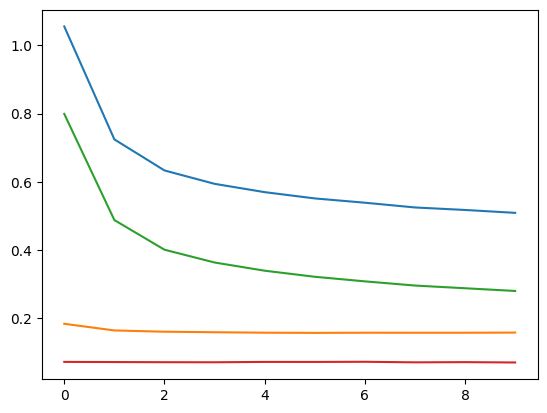

In [8]:
Loss_G=np.array(history.history['loss'])
Loss_bin = np.array(history.history['reshape_1_loss'])
Loss_clas = np.array(history.history['dense_5_loss'])
Loss_KL = Loss_G - Loss_bin - Loss_clas
plt.plot(range(0,ep),Loss_G)
plt.plot(range(0,ep),Loss_bin)
plt.plot(range(0,ep),Loss_clas)
plt.plot(range(0,ep),Loss_KL)
#save_fig("keras_learning_curves_plot")
plt.show()

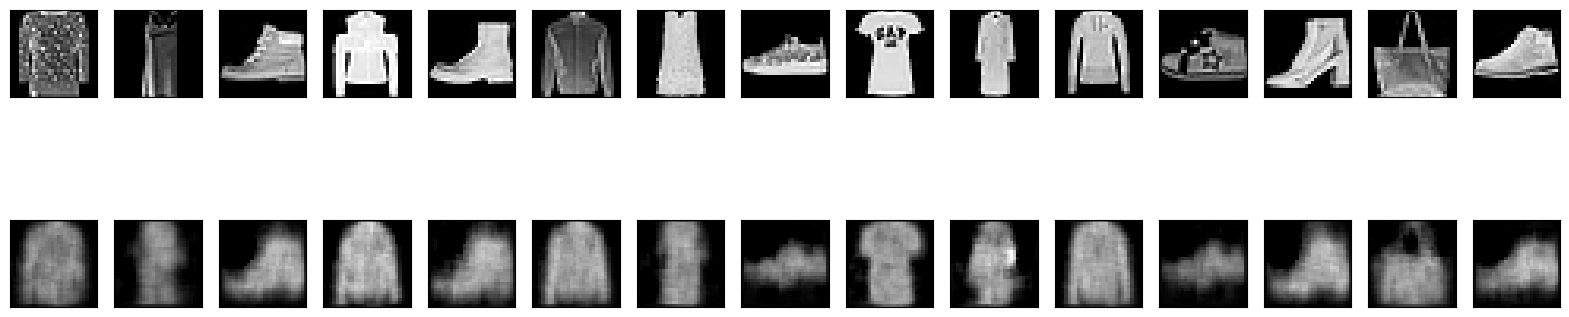

Y_real:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Y_pred:  tf.Tensor(
[[5.61750047e-02 1.15417088e-05 1.54602915e-01 1.12624234e-02
  1.86680499e-02 2.83732845e-07 7.56341159e-01 5.27666466e-10
  2.93863169e-03 4.14527044e-08]
 [1.84219375e-01 1.11286834e-01 1.25189032e-02 5.66737413e-01
  7.35806208e-03 1.05770631e-02 9.03725922e-02 1.17593608e-03
  1.14923632e-02 4.26141405e-03]
 [1.15275834e-04 2.08220410e-08 3.30807143e-06 2.42697206e-06
  6.39985629e-08 5.89449483e-05 1.61344042e-06 4.27365908e-03
  3.95112402e-05 9.95505154e-01]
 [9.

In [9]:
x_prueb = x_ts[:15,:,:,:]
c=model_fun(x_prueb)
plot_mnist_autoencoder(x_ts[:15],c[0])
print("Y_real: ",y_test[0:15,:])
print("Y_pred: ", c[1])

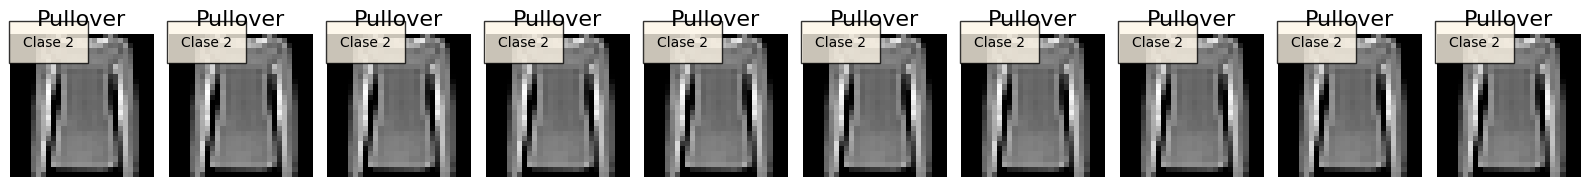

In [10]:


# Image titles
clases_y = ["T-shirt/top", "Trouser", "Pullover",	"Dress", 	"Coat", "Sandal", "Shirt", 	"Sneaker", "Bag", "Ankle boot"]
 # T-shirt/top, 	Trouser, Pullover,	Dress, 	Coat, Sandal, Shirt, 	Sneaker, Bag, Ankle boot

# Load images and Convert them to a Numpy array
img1 = x_ts[200,:,:,0]
img2 = x_ts[200,:,:,0]
img3 = x_ts[1300,:,:,0]
images = np.array([img1, img1, img1, img1, img1, img1, img1, img1, img1, img1])

# Imagenes de prueba para GradCAM++
Img_GC = np.array([x_ts[200,:,:,:], x_ts[200,:,:,:], x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:],  x_ts[200,:,:,:]])

y_real = np.array([y_test[200,:],y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:], y_test[200,:]])
c=model_fun(Img_GC)

y_classes = [np.argmax(y, axis=None, out=None) for y in c[1][:]]
image_titles = [ y for y in y_classes]
image_titles = [clases_y[y] for y in image_titles]
y_c_t = [np.argmax(y, axis=None, out=None) for y in y_real]
#x_prueb = x_ts[:15,:,:,:]
#c=model_fun(x_prueb)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=10, figsize=(16, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i]*255, cmap="gray", vmin=0, vmax=255,)
    ax[i].text(2, 2, 'Clase {}'.format(y_classes[i]), bbox = {'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 10})
    ax[i].axis('off')
plt.tight_layout()
plt.show()

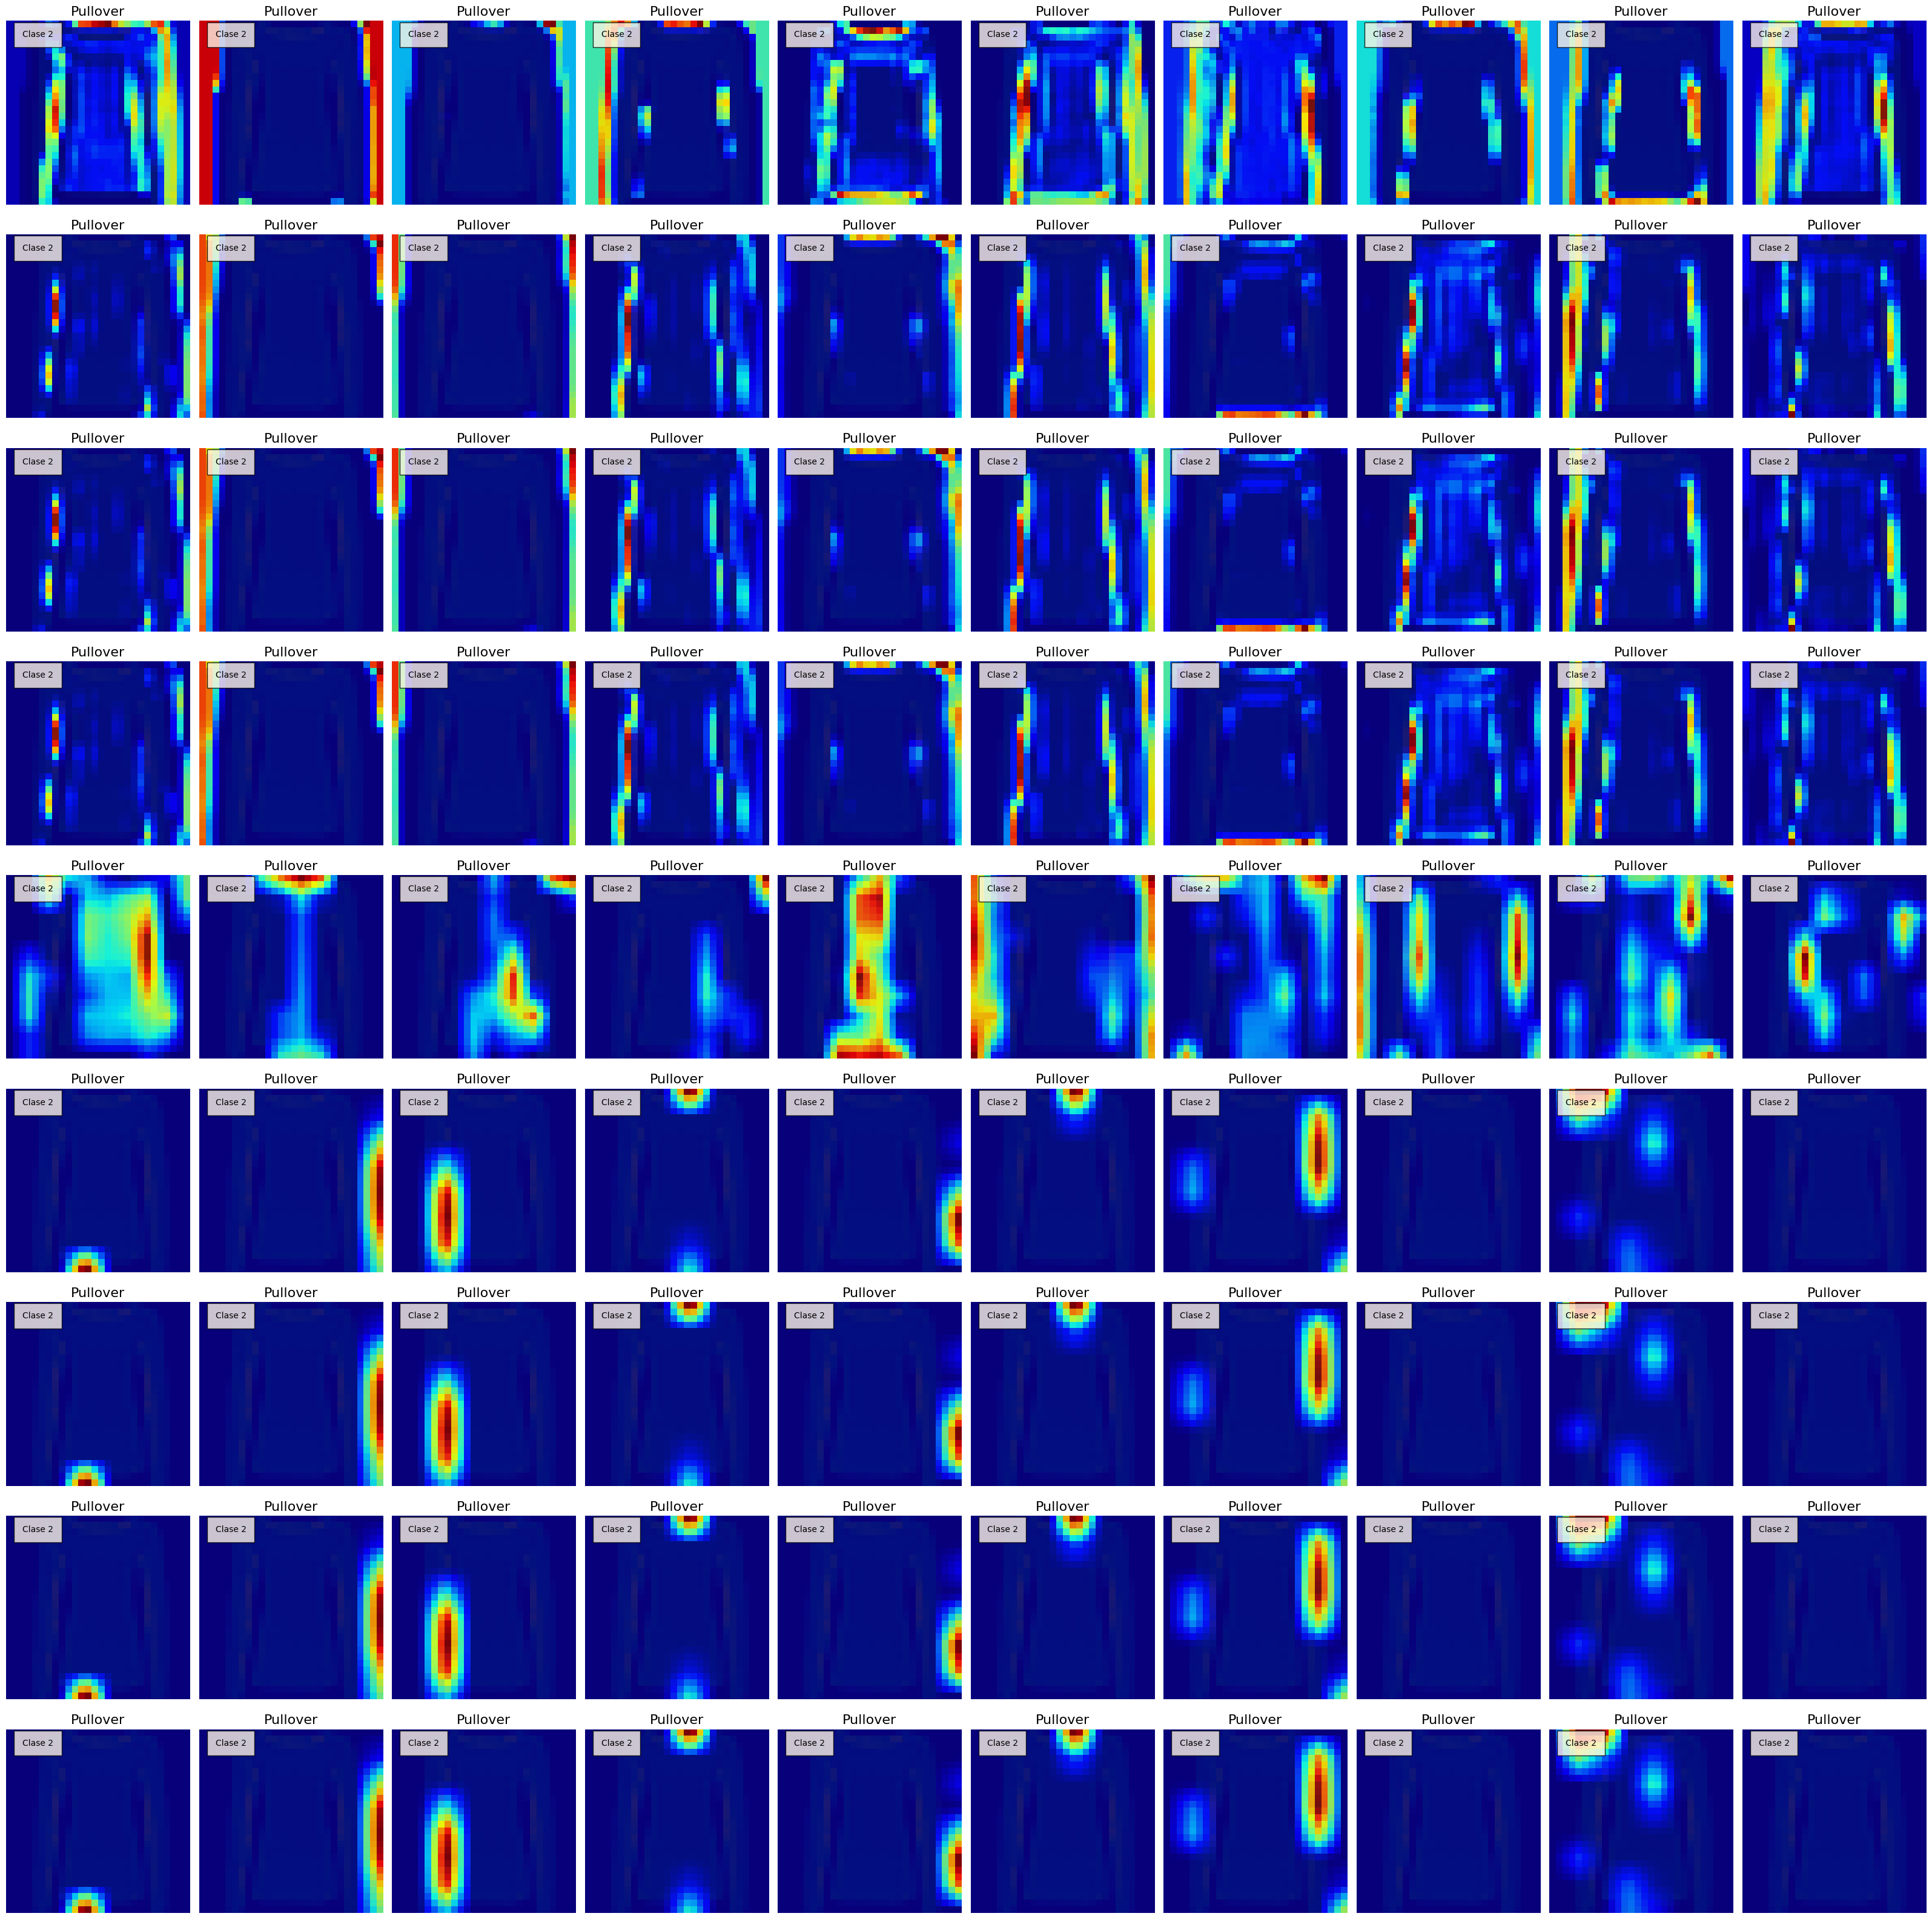

In [14]:
replace2linear = ReplaceToLinear()
score = [CategoricalScore([0,1,2,3,4,5,6,7,8,9]) ]
N_layer = 9
N_img  = 10
#score = CategoricalScore([0,1])
# Create GradCAM++ object


#Nombres de las capas del modelo['entrada', 'conv2d', 'conv2d_1', 'max_pooling2d', 'dropout', 'conv2d_2', 'conv2d_3', 'max_pooling2d_1',
# 'dropout_1', 'flatten', 'dense', 'reshape', 'conv2d_transpose', 'conv2d_transpose_1', 'dense_1', 'conv2d_transpose_2', 'dense_2', 'reshape_1', 'dense_3']


# Render
f, ax = plt.subplots(nrows=N_layer, ncols=N_img, figsize=(32, 32))
suma_matrices = []
for j in range(N_layer):
    gradcam = GradcamPlusPlus(model_fun,
                          model_modifier=[ExtractIntermediateLayer(j+1),
                                        ReplaceToLinear()])
    cam = gradcam(score,Img_GC)
    suma_matrices.append(cam.sum(axis=(1, 2)))
    for i,title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3]*255 )
        ax[j,i].set_title(title, fontsize=16)
        ax[j,i].imshow(images[i])
        ax[j,i].imshow(heatmap, cmap='jet', alpha=0.9)
        ax[j,i].text(2, 2, 'Clase {}'.format(y_classes[i]), bbox = {'facecolor': 'oldlace', 'alpha': 0.8, 'pad': 10})
        ax[j,i].axis('off')
plt.tight_layout()
plt.show()
#suma_matrices.append(sum(suma_matrices))
suma_matrices = np.array(suma_matrices)

suma_matrices = suma_matrices.T

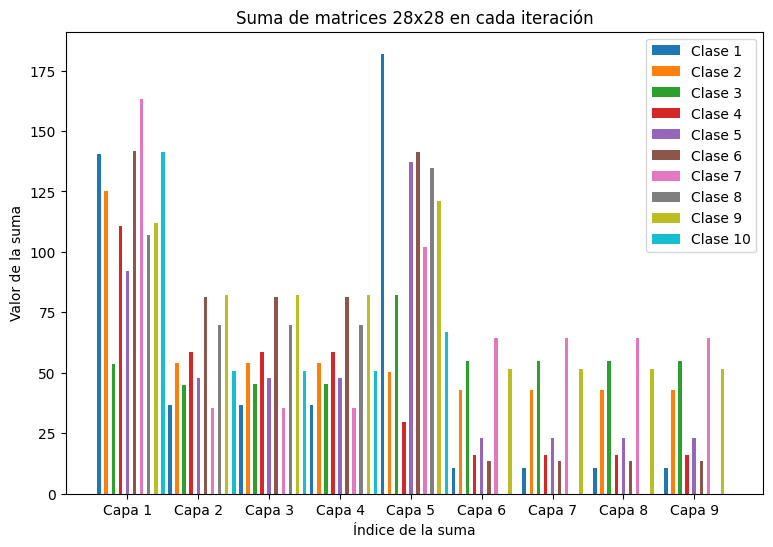

In [16]:
fig, ax = plt.subplots(figsize=(N_layer, 6))

for i in range(N_img):
    ax.bar(np.arange(N_layer) + i * 0.1, suma_matrices[i], width=0.05, label=f'Clase {i+1}')

# Ajustar las etiquetas del eje x para reflejar las diferentes iteraciones
ax.set_xticks(np.arange(N_layer) + 0.8 / 2)
ax.set_xticklabels([f'Capa {i+1}' for i in range(N_layer)])

# Agregar etiquetas y título
ax.set_xlabel('Índice de la suma')
ax.set_ylabel('Valor de la suma')
ax.set_title('Suma de matrices 28x28 en cada iteración')
ax.legend()

# Mostrar el gráfico
plt.show()